# Results Analysis

`EP3.75` is the case where the average LMP price is $0.0375/kWh

`GC_0` is the no grid charging case where:
 - Battery only charges from PV
 - PV and Battery both receive ITC of 22%
 - Wind does not receive PTC
 
`GC_1` is the grid charging case where:
 - Battery charges from PV, Wind and Grid
 - PV receives ITC of 22%
 - Battery receives no ITC
 - Wind receives PTC of $0.015/kWh

In [21]:
# %matplotlib notebook
# import mpld3
# mpld3.enable_notebook()
import os
from pathlib import Path
import sys

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
print('workbookDir: ' + workbookDir)
os.chdir(workbookDir)

sys.path.append("/Users/dguittet/Projects/HybridSystems/HOPP")
sys.path.append("/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos")

import pandas as pd
import os
import re
import sys
import json
from pprint import pprint
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from math import *

from cycler import cycler

import json_lines # https://github.com/TeamHG-Memex/json-lines

from IPython.display import display, HTML


from matplotlib.animation import (
    PillowWriter,
    )
from matplotlib.lines import Line2D
from pylab import rcParams

from hybrid.sites import SiteInfo

from tools.optimization import setup_run, NullDataRecorder


font = {'family' : 'monospace',
        'weight' : 'medium',
        'size'   : 19}
plt.rc('font', **font)

directory = Path('/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos')
resource_dir = directory / "resource_files"
params_dir = directory / "parameter_files"
results_dir = directory / "results"

workbookDir: /Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results


# Plot Grid Search Results with No Layout

### Each of these 3D grids are created by simulating the hybrid plant performance and NPV without adding boundary constraints and wake losses. Instead, the turbines are only determined by the desired system capacity and the wake losses are fixed to 5%. This will result in overestimation of the optimal capacity of wind and pv.

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV
Max NPV of -0.8217406027660668 with 1 PV, 6 Wind and 0 Battery


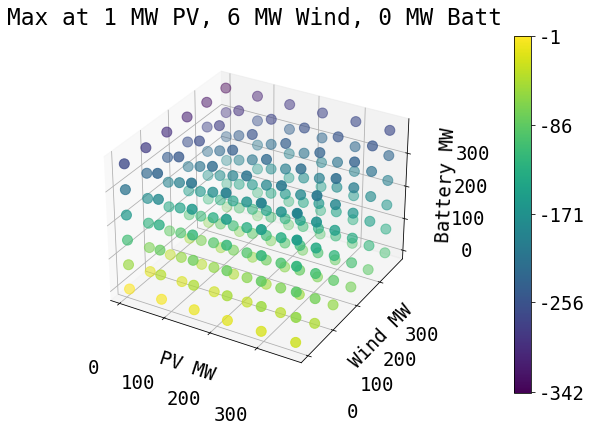

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4_GC_1_NPV
Max NPV of 129.2421343414403 with 1 PV, 366 Wind and 0 Battery


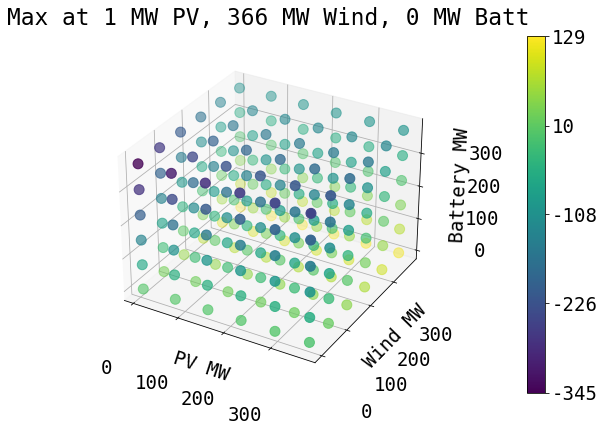

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4_GC_0_NPV
Max NPV of -0.0743910264149811 with 1 PV, 6 Wind and 0 Battery


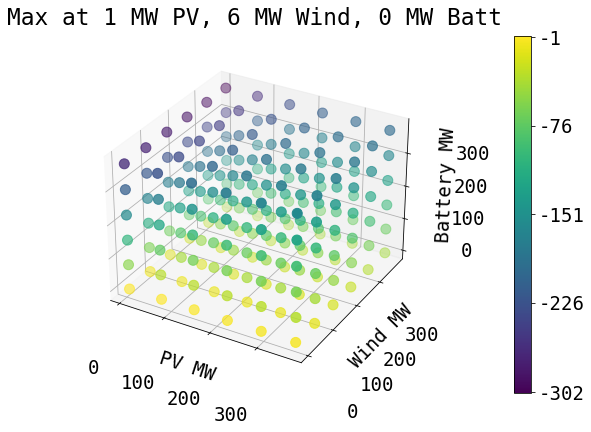

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_1_NPV
Max NPV of 89.19620451360296 with 1 PV, 366 Wind and 0 Battery


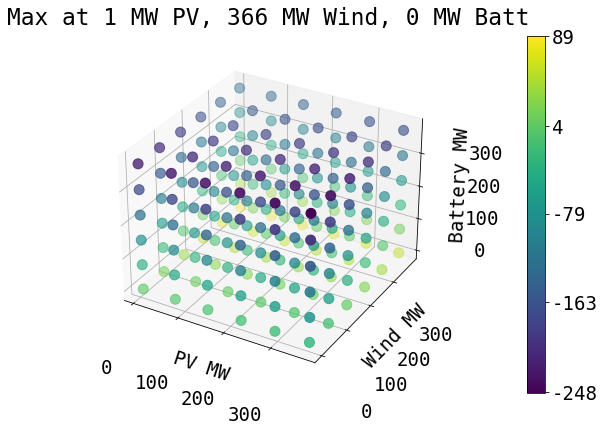

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_NPV
Max NPV of 19.581865871880293 with 376 PV, 366 Wind and 0 Battery


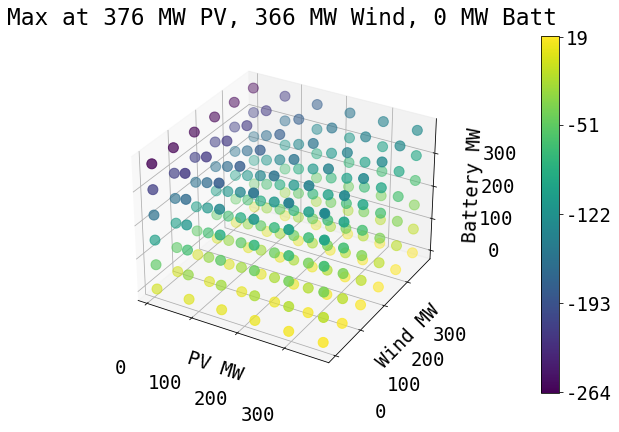

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_1_NPV
Max NPV of 180.22355113002158 with 376 PV, 366 Wind and 0 Battery


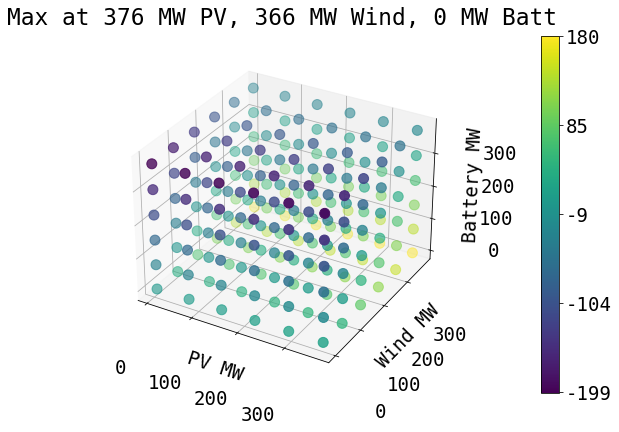

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4_GC_0_CAP
Max NPV of -0.0743910264149811 with 1 PV, 6 Wind and 0 Battery


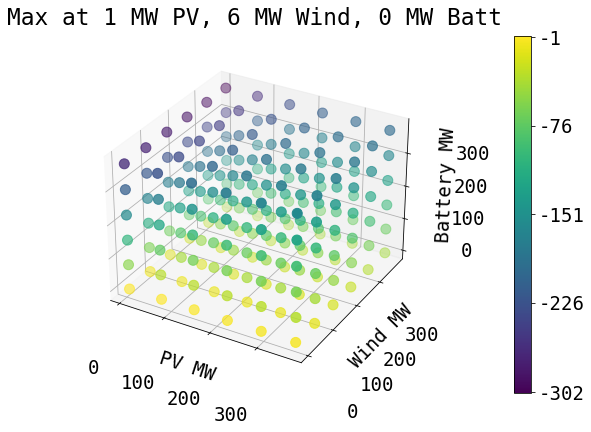

/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_CAP
Max NPV of 19.581865871880293 with 376 PV, 366 Wind and 0 Battery


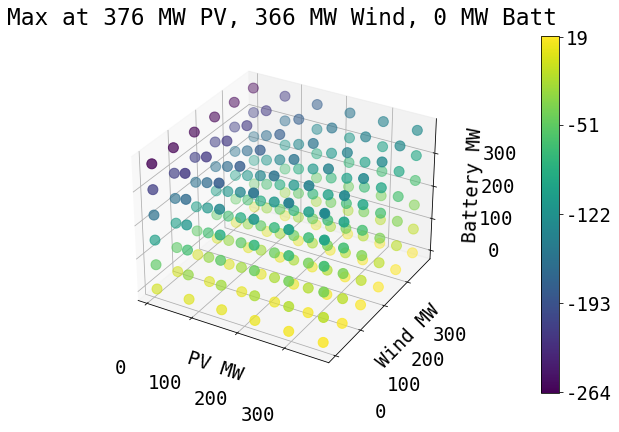

In [80]:
from mpl_toolkits.mplot3d import Axes3D
import glob

rcParams['figure.figsize'] = 8, 12
rcParams['axes.titlepad'] = 20 
rcParams['xtick.major.pad']='32'

def plot_grid(output_file):
    output_res = json.load(open(output_file, "r"))
    # Max NPV coordinates 1 366 375 172659761.8127966
    # organize data

    X = []  # solar
    Y = []  # wind
    Z = []  # battery
    NPV = []
    AEP = []
    REV = []
    CAP_PV = []
    for i in output_res:
        X.append(i[0][0])
        Y.append(i[0][1])
        Z.append(i[0][2])
        AEP.append(json.loads(i[1])['hybrid'])
        npv = json.loads(i[-2])['hybrid']
        if npv < -1e37:
            npv = min(NPV)
        NPV.append(npv)
        REV.append(json.loads(i[3])['hybrid'])
        CAP_PV.append(json.loads(i[2])['pv'])
    x_inds = sorted(list(set(X)))
    y_inds = sorted(list(set(Y)))
    z_inds = sorted(list(set(Z)))
    Xs, Ys, Zs = np.meshgrid(x_inds, y_inds, z_inds)
    NPVs = np.zeros(Xs.shape)
    AEPs = np.zeros(Xs.shape)
#     print("PV, Wind, Batt, NPV (mil)")
    for i in output_res:
        x = i[0][0]
        y = i[0][1]
        z = i[0][2]
        x_ind = x_inds.index(x)
        y_ind = y_inds.index(y)
        z_ind = z_inds.index(z)
        aep = json.loads(i[1])['hybrid']
        npv = json.loads(i[-2])['hybrid']
        cf = json.loads(i[2])
        if npv < -1e37:
            npv = min(NPV)
        NPVs[y_ind, x_ind, z_ind] = npv * 1e-6
        AEPs[y_ind, x_ind, z_ind] = aep

    # get max NPV
    max_ind = int(np.argmax(NPV))
    print(Path(output_file).parent)
    print(f"Max NPV of {NPV[max_ind] * 1e-6} with {X[max_ind]} PV, {Y[max_ind]} Wind and {Z[max_ind]} Battery")

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # ax.plot_trisurf(X, Y, Z, edgecolor="gray", color="None")
    img = ax.scatter(Y, X, Z, c=NPVs, s=100)
    # ax.scatter( X[max_ind], Y[max_ind], Z[max_ind], s=320, marker='*', color='tomato')
    ax.set_xlabel("PV MW")
    ax.set_ylabel("Wind MW")
    ax.set_zlabel("Battery MW")
    cbar = fig.colorbar(img, fraction=0.04, pad=0.2)
    m0 = int(np.ceil(NPVs.min()))            # colorbar min value
    m4 = int(np.floor(NPVs.max()))             # colorbar max value
    m1 = int(1 * (m4-m0) / 4.0 + m0)               # colorbar mid value 1
    m2 = int(2 * (m4-m0) / 4.0 + m0)               # colorbar mid value 2
    m3 = int(3 * (m4-m0) / 4.0 + m0)               # colorbar mid value 3
    cbar.set_ticks([m0, m1, m2, m3, m4])
    cbar.set_ticklabels([m0, m1, m2, m3, m4])
#     plt.suptitle(f"Grid of NPVs in $M")
    plt.title(f"Max at {X[max_ind]} MW PV, {Y[max_ind]} MW Wind, {Z[max_ind]} MW Batt")
    plt.savefig(Path(output_file).parent / "grid_view.png")
    plt.show()

for f in glob.glob(str(results_dir / "*" / "*grid.json")):
    plot_grid(f)

# Plot Optimal Layouts

### Now go through the optimal sizing with layout and boundary constraints: adding flicker, wake losses

Due to randomness in the optimization algorithm, each folder's configuration was run 3 times to see a multiple of optimal results.

In [89]:
# print(os.listdir('.'))
# print(os.path.dirname(os.path.realpath('.')))

def load_results(path, run_group, index='iteration'):
#     run_name_extractor = re.compile(r'^(.*)_(\d\d\d\d\-\d\d\-\d\dT\d\d\.\d\d\.\d\d\.\d+)$')
    run_name_extractor = re.compile(r'^(.*)_([^_]+)$')
    
    dirs = [f for f in os.listdir(path)]
    print(dirs)
    data_sets = {}
    for d in dirs:
        
        dir_path = os.path.join(path, d)
        print(dir_path)
        if '.jsonl' not in dir_path:
            continue
            
        if 'copy' in dir_path:
            continue
    
        f = os.path.join(dir_path)
        
        columns = []
        data = None
        with open(f, 'rb') as file:
            print(f)
            columns = next(json_lines.reader(file))

            data_set = pd.DataFrame(json_lines.reader(file), columns = columns)

        data_set.set_index(index, inplace=True)
        
        run_name = f.split('/')[-1].split('.log')[0]
        print(run_name)
        
        if run_group not in data_sets:
            data_sets[run_group] = {}
        run_data_sets = data_sets[run_group]
        run_data_sets[run_name] = data_set
        
    return data_sets

def make_aggregated_data_set(data_sets):
    aggregated_data_sets = {}
    for run_group, runs in data_sets.items():
        group_data = {}
        for run_name, data_set in runs.items():
            for column in data_set.columns:
                if column not in group_data:
                    group_data[column] = pd.DataFrame()
                group_data[column][run_name] = data_set[column]
        aggregated_data_sets[run_group] = group_data
    return aggregated_data_sets


def extract_solution_vars(data_sets, solution_vars, solution_name = 'best_solution'):
    for run_group, runs in data_sets.items():
        for run_name, data_set in runs.items():
            solutions = data_set[solution_name]
            if solution_vars is None:
                solution_vars = sorted(solutions.iloc[0].keys())
            for n, var in enumerate(solution_vars):
                data_set[solution_name + '.' + var] = [row[n] for row in solutions]
    return solution_vars

def unpack_solution_vars(data_sets, solution_vars, solution_name):
    for run_group, runs in data_sets.items():
        for run_name, data_set in runs.items():
            solutions = data_set[solution_name]
            for i, var in enumerate(solution_vars):
                data_set[solution_name + '.' + var] = [row[i] for row in solutions]
            
def load_and_preprocess(directory, run_name):
    data_sets = load_results(directory, run_name)
#     print('data_sets', data_sets)
    extract_solution_vars(data_sets, solution_vars)
    unpack_solution_vars(data_sets, solution_vars, 'mean')
    unpack_solution_vars(data_sets, solution_vars, 'variance')
    aggregated_data_sets = make_aggregated_data_set(data_sets)

#     for j, (run_group, group_data) in enumerate(aggregated_data_sets.items()):
#         print(run_group)
    return data_sets, aggregated_data_sets, solution_vars


In [70]:
from pathlib import Path
from optimize_npv import HybridLayoutProblem, WindBoundaryGridParameters, PVGridParameters, module_power, simulation_options
from hybrid.sites import make_irregular_site

solution_vars = ["border_spacing", "border_offset", "grid_angle", "grid_aspect_power", "row_phase_offset", "num_turbines_ratio_max", "solar_x_position", "solar_y_position", "solar_aspect_power", "solar_gcr", "solar_s_buffer", "solar_x_buffer", "solar_ratio_of_max_mw", "battery_ratio_of_max_mw"]
location = (32.4386, -99.7336, 0)

def create_hybrid_plant():
    solar_file = resource_dir / "32.43861838431444__-99.73363995829895_32.438818_-99.734703_psm3_60_2013.csv"
    wind_file = resource_dir / "lat32.43_lon-99.73__2013_120m.srw"
    prices_file = resource_dir / "pricing-data-2015-IronMtn-002_factors.csv"
    site = SiteInfo(make_irregular_site(lat=location[0], lon=location[1], elev=location[2]),
                    solar_resource_file=solar_file,
                    wind_resource_file=wind_file,
                    grid_resource_file=prices_file)
    
    with open(params_dir / "pv_parameters.json", 'r') as f:
        pv_info = json.load(f)["SystemDesign"]
    with open(params_dir / "wind_parameters.json", 'r') as f:
        wind_info = json.load(f)
    turb_rating_kw = max(wind_info['Turbine']['wind_turbine_powercurve_powerout'])
    with open(params_dir / "financial_parameters.json", 'r') as f:
        fin_info = json.load(f)
    cost_info = fin_info['capex']
        
    problem = HybridLayoutProblem(site_info=site, cost_config=dict(), sim_config=simulation_options, dispatch_config=dict(), 
                                  turb_size_kw=6000, pv_config=pv_info, wind_config=wind_info,
                                  fin_config=fin_info)
    return problem

problem = create_hybrid_plant()

bounds = problem.site.polygon.bounds
site_sw_bound = np.array([bounds[0], bounds[1]])
site_ne_bound = np.array([bounds[2], bounds[3]])
site_center = .5 * (site_sw_bound + site_ne_bound)
max_delta = max(bounds[2] - bounds[0], bounds[3] - bounds[1])
reach = (max_delta / 2) * 1.3
min_plot_bound = site_center - reach
max_plot_bound = site_center + reach

In [145]:
# colors = [
#     (0.0,0.0,1.0),
#     (0.0,1.0,0.0),
#     (1.0,0.0,0.0),
#     (0.0,0.7,0.7),
#     (0.7,0.7,0.0),
#     (0.0,0.0,0.0),
#     (0.5,0.5,0.5),
# ]

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# plt.style.use('seaborn-whitegrid')
plt.ion()

rcParams['lines.linewidth'] = 4

wind_color = (153 / 255, 142 / 255, 195 / 255)
solar_color = (241 / 255, 163 / 255, 64 / 255)
batt_color = (65 / 255, 121 / 255, 251 / 255)
flicker_color = (27/255.0,158/255.0,119/255.0)


colors = [
#     (67/255.0,185/255.0,269/255.0),
    (223 / 255, 142 / 255, 195 / 255),
    (86 / 255, 163 / 255, 64 / 255),
    (165 / 255, 121 / 255, 251 / 255),
#     (127/255.0, 58/255.0,119/255.0)
]

solar_max_mw = 300
turbines_max = 62
battery_max_mw = 300
def plot_site(candidate, min_plot_bound, max_plot_bound, site_fig_size, title):

    site_border_color = (0, 0, 0)
    fig, ax = plt.subplots(1, figsize=site_fig_size)
    ax.axis('scaled')
    ax.set(xlim=(min_plot_bound[0], max_plot_bound[0]), ylim=(min_plot_bound[1], max_plot_bound[1]))
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis("off")
    ax.margins(y=0, x=0)
    
    problem = create_hybrid_plant()
    simulation = problem._set_simulation_to_candidate(candidate)
    simulation.site.plot(fig, ax, site_border_color)
    simulation.layout.plot(fig, ax,
                           wind_color=wind_color,
                           pv_color=solar_color,
                           site_border_color=site_border_color,
                           alpha=1)
    
    plt.tight_layout()
    wind_mw = simulation.wind.num_turbines * 6
    solar_mw = simulation.pv.system_capacity_kw * 1e-3
    batt_mw = simulation.battery.system_capacity_kw * 1e-3
    plt.title(f"{round(wind_mw)} MW Wind, {round(solar_mw)} MW Solar, {round(batt_mw)} MW Battery")
    plt.suptitle(title)
    plt.margins(0,0)
    plt.show()

    return fig
    
def plot_sites(runs, group_name, site_fig_size):
    ds = None
    for j, (run_name, data_set) in enumerate(runs.items()):
        if run_name == "README":
            continue
        ds = data_set
        json_candidate = data_set.at[len(data_set.index)-1, 'best_solution']
        evaluation = data_set.at[len(data_set.index)-1, 'best_evaluation']
        title = f"Best NPV ${round(evaluation * 1e-6, 2)}M"
        fig = plot_site(json_candidate, min_plot_bound, max_plot_bound, site_fig_size, title)
        score = data_set.at[len(data_set.index)-1, 'best_score']
        baseline_value = data_set.at[data_set.index[0], 'best_score']

        print(json_candidate, score, evaluation, run_name)

#         plt.label(str(evaluation / 1e3) + 'GWh AEP')
#         plt.savefig(group_name + '_' + str(j) + '_layout.svg')
        fig.savefig(results_dir / "fig_layout.png")
#         fig2.savefig(group_name + '_' + str(j) + '_stats.svg')
    
    return json_candidate, evaluation, score, baseline_value

In [111]:

def smooth_aggregated_column(aggregated_column, window_size):
    print('ws ', window_size)
    return aggregated_column.rolling(window=window_size,axis=0).mean()

def plot_quantile(ax, x, aggregated_column, color=(0,0,.8), alpha=.25, value=.5):
    q1 = aggregated_column.quantile(.5+value/2, 1).values.tolist()
    q2 = aggregated_column.quantile(.5-value/2, 1).values.tolist()
    ax.fill_between(x, q1, q2, color=(*color, alpha))

def plot_quantiles(ax, x, aggregated_column, color=(0,0,.8), alpha=.5, value=.5):
#     plot_quantile(ax, x, aggregated_column, color, alpha, value)
    plot_quantile(ax, x, aggregated_column, color, alpha * .5, value * 2)
    ax.plot(x, aggregated_column.quantile(.5, 1), color=color)

def plot_smooth_quantiles(x, aggregated_column, window_size=5, **kwargs):
    plot_quantiles(x, smooth_aggregated_column(aggregated_column, window_size), **kwargs)
    
def normalize_sequence(seq):
    hi = max(seq)
    lo = min(seq)
    scale = max(1e-6, hi - lo)
    return [(x-lo) / scale for x in seq]


def setup_minor_ticks(ax):
    ax.minorticks_on()
    ax.tick_params(which='major', length=8)
    ax.tick_params(which='minor', length=4)

def plot_perf(aggregated_data_sets, baseline_value, ordering, figsize=(10,8)):
    def aep_to_pct(x):
        return x * 1e-6

    def gwh_to_pct(x):
        return x

    def pct_to_gwh(y):
        return y

    fig, ax = plt.subplots(1, figsize=figsize)
    
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(5))
    setup_minor_ticks(ax)

    ax.minorticks_on()

    plt.ylabel('NPV ($mil)')
    plt.xlabel('# of candidates evaluated')
    
    labels = []
        
    for i, run_group in enumerate(ordering):
        run_data = aggregated_data_sets[run_group]
        scores = run_data['best_evaluation']
        pct = aep_to_pct(scores)
        plot_quantiles(ax, run_data['num_evaluations'].median(1) + 200, pct, color=colors[i%len(colors)])
        labels.append(run_group)
        
#         print(scores.mean(1).values[-1])
        print('{} mean {} stdev {} median {}\n'.format(run_group, pct.mean(1).values[-1], pct.std(1).values[-1], pct.median(1).values[-1]))
    
    return fig, ax, None


## Load the Data

Collect the 3 trials per run configuration

In [95]:
runs = ("EP3.75_GC_0_NPV", "EP3.75_GC_1_NPV", "EP4_GC_0_NPV", "EP4_GC_1_NPV", "EP4.25_GC_0_NPV", "EP4.25_GC_1_NPV", "EP3.75_GC_0_CAP", "EP4_GC_0_CAP", "EP4.25_GC_0_CAP", )
# runs = ["25_GC_0_NPV"]
aggregated_data_sets = dict()
data_sets = dict()
for r in runs:
    data_set, aggregated_data_set, _ = load_and_preprocess(results_dir / r, r)
    data_set[r]['README'] = json.load(open(results_dir / r / "README.json"))
    aggregated_data_sets.update(aggregated_data_set)
    data_sets.update(data_set)
aggregated_data_sets.keys()


['results.log.jsonl', 'results1.log.jsonl', 'README.json', 'results2.log.jsonl', 'grid_view.png', 'hybrid_size_grid.json']
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/results.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/results.log.jsonl
results
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/results1.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/results1.log.jsonl
results1
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/README.json
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/results2.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/results2.log.jsonl
results2
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP3.75_GC_0_NPV/grid_view.png
/Users/dg

EP4_GC_0_CAP dict_keys(['EP4_GC_0_CAP'])
['results.log.jsonl', 'results1.log.jsonl', 'README.json', 'results2.log.jsonl', 'grid_view.png', 'hybrid_size_grid.json']
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_CAP/results.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_CAP/results.log.jsonl
results
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_CAP/results1.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_CAP/results1.log.jsonl
results1
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_CAP/README.json
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_CAP/results2.log.jsonl
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/results/EP4.25_GC_0_CAP/results2.log.jsonl
results2
/Users/dguittet/Projects/HybridSystems/HOPP/examples/HOPP-demos/result

dict_keys(['EP3.75_GC_0_NPV', 'EP3.75_GC_1_NPV', 'EP4_GC_0_NPV', 'EP4_GC_1_NPV', 'EP4.25_GC_0_NPV', 'EP4.25_GC_1_NPV', 'EP3.75_GC_0_CAP', 'EP4_GC_0_CAP', 'EP4.25_GC_0_CAP'])

In [97]:
print(data_sets['EP4.25_GC_0_CAP']['results']['best_score'].values[-1],
data_sets['EP4.25_GC_0_CAP']['results1']['best_score'].values[-1],
data_sets['EP4.25_GC_0_CAP']['results2']['best_score'].values[-1])
print(data_sets['EP4.25_GC_0_CAP']['README'])

29184564.85854415 28712913.556013282 27321720.1831431
{'energy_price_base': 4.25, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX', 'cp_capacity_payment_amount': 65000}


## Explore Results with both Wind and Solar Tax Incentives, Battery charging from Grid, Solar and Wind

{'energy_price_base': 3.75, 'grid_charging': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.015], 'location': 'TX'}


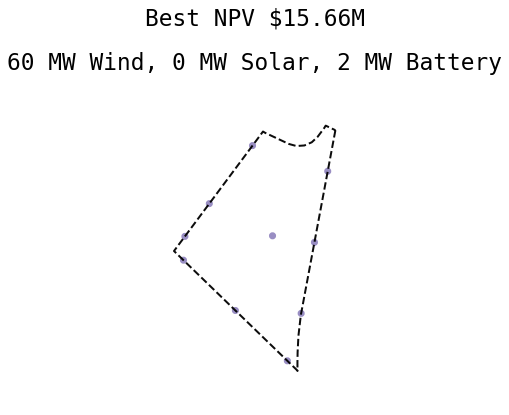

[8.55426468134555, 0.5770801684514062, 3.1348720014000446, 2.2864194100678605, 0.6296392107491329, 0.8127064328824869, 1.0, 0.4393674991933152, 1.2430633447226735, 0.4720067346756447, 9.0, 7.581762374494562, 0.0, 0.005608804385906701] 15658308.42041463 15658308.896510124 results


Could not fit 8121.942000000001 kw into existing PV layout parameters of PVGridParameters(x_position=0.9195340392900184, y_position=0.5694651440569067, aspect_power=-4.0, gcr=0.1, s_buffer=1.0518108704659372, x_buffer=7.400017932035946)


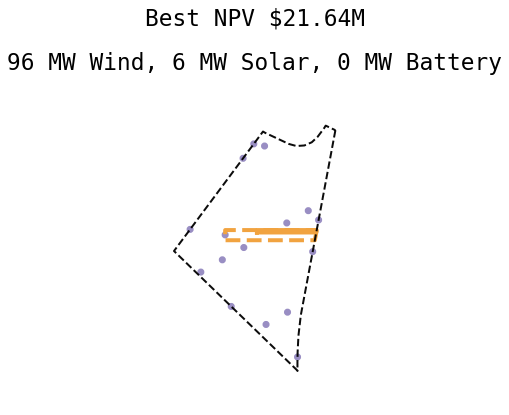

[13.089053753835184, 0.8566356533379924, 2.622427626160114, 1.145761069608162, 0.7627092044631634, 0.6736951829449322, 0.9195340392900184, 0.5694651440569067, -4.0, 0.1, 1.0518108704659372, 7.400017932035946, 0.027073384206113604, 0.0009795099558542186] 21635348.035176724 21635353.99742967 results1


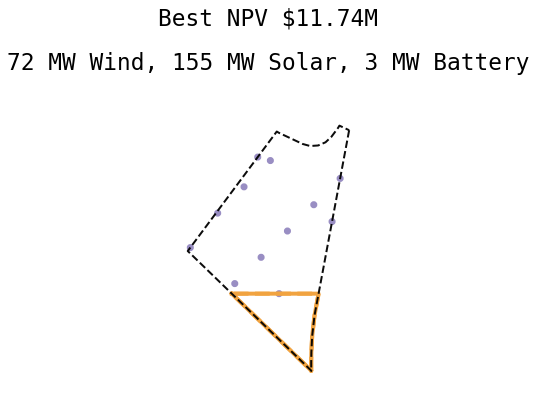

[13.913523884807153, 0.8235348189613603, 0.7938992338220262, -0.5095303825240174, 0.9954927020172455, 0.20203528360403755, 0.11604662190334614, 0.0669513732830253, -1.2464885025399974, 0.1, 7.794491528362853, 5.616508399850583, 0.5162511455480834, 0.010036443777775315] 11738088.030735193 11738181.8316679 results2
[13.913523884807153, 0.8235348189613603, 0.7938992338220262, -0.5095303825240174, 0.9954927020172455, 0.20203528360403755, 0.11604662190334614, 0.0669513732830253, -1.2464885025399974, 0.1, 7.794491528362853, 5.616508399850583, 0.5162511455480834, 0.010036443777775315] 11738181.8316679 11738088.030735193 -49671879.30703893


In [127]:
current_run = run_group = 'EP3.75_GC_1_NPV'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

{'energy_price_base': 4, 'grid_charging': 0, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.015], 'location': 'TX'}


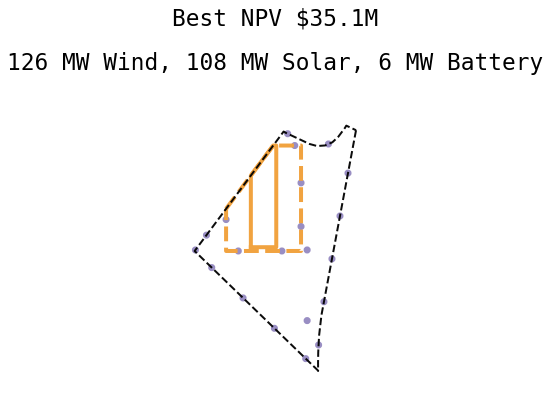

[4.764259364332027, 1.0, 3.141592653589793, 0.23462663951551777, 1.0, 0.34206085113072565, 0.42708676880771634, 0.7117563711389776, 1.3864388025451104, 0.1, 0.0, 5.5463477416990425, 0.3605389735129395, 0.01887926585979759] 35096422.31636623 35096435.07021099 results


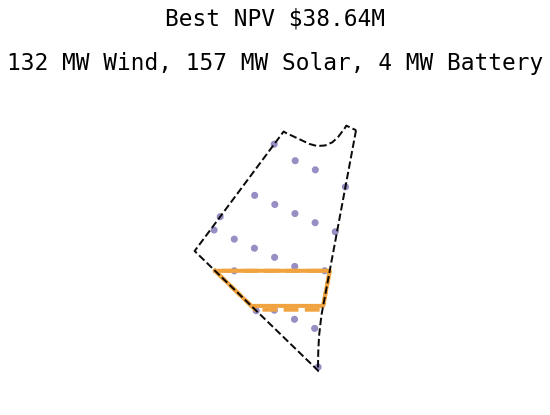

[10.950127125539703, 0.6370711444528725, 1.0573443749932898, -1.8303655458066812, 0.21850657142936702, 0.364195920552846, 0.7898813156999299, 0.3368636754165076, -4.0, 0.1, 0.0, 4.430228265371239, 0.5242025550374775, 0.012968082495838293] 38636732.33941146 38636783.396837056 results1


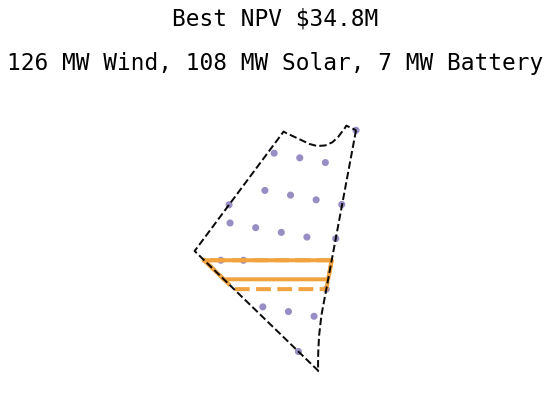

[13.57144811818338, 0.0, 1.9252413072883239, -4.0, 0.16345944942527435, 0.3545122988650703, 0.5822914499588747, 0.4124941653287013, -4.0, 0.10389077928053186, 1.5887528294244588, 0.0, 0.3604175545207915, 0.024123347903460268] 34804718.9762906 34804737.497733116 results2
[13.57144811818338, 0.0, 1.9252413072883239, -4.0, 0.16345944942527435, 0.3545122988650703, 0.5822914499588747, 0.4124941653287013, -4.0, 0.10389077928053186, 1.5887528294244588, 0.0, 0.3604175545207915, 0.024123347903460268] 34804737.497733116 34804718.9762906 -6065352.302922368


In [128]:
current_run = run_group = 'EP4_GC_1_NPV'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

{'energy_price_base': 4.25, 'grid_charging': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.015], 'location': 'TX'}


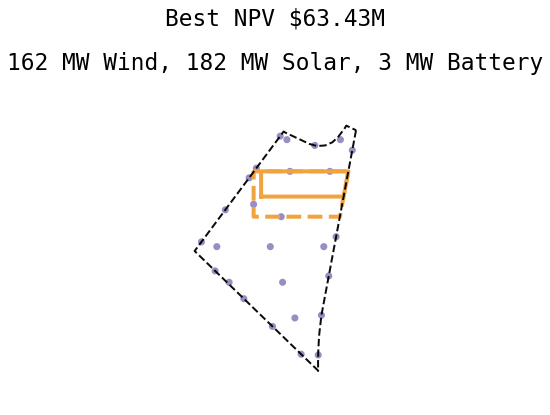

[4.277015828506016, 0.509881631963763, 3.141592653589793, -0.40524681412724906, 0.7701112115225583, 0.43899912717548045, 0.7327013641802729, 0.7623341353643145, -1.412184634371493, 0.3149578925279668, 4.3186975957964275, 0.9843775997683757, 0.6077832173974904, 0.010431902974099315] 63428591.22929705 63428592.95354718 results


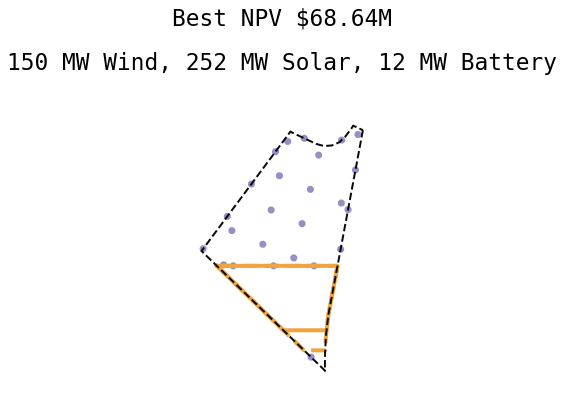

[4.338331278383588, 1.0, 2.2847410450721384, -1.5020270100304263, 0.4314798720741066, 0.40422933350422746, 0.43442972376269473, 0.29728701894024134, -0.8442128884366926, 0.1, 4.307520979142147, 6.673602438041312, 0.8401779574432586, 0.03855903447028586] 68642942.57442318 68642987.17967963 results1


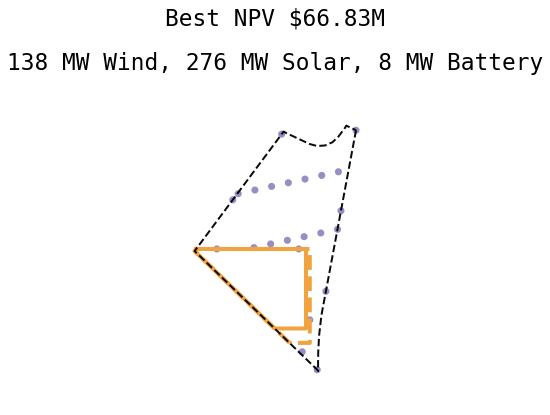

[9.82551751857456, 0.0, 1.4384930438599546, -2.580274300219207, 0.49370702298772157, 0.37624700730966454, 0.2180446078894578, 0.3353533514716438, -0.6506124942579722, 0.1, 2.818055293400625, 0.0, 0.920628778340449, 0.02578196920958771] 66827850.27790253 66827852.68381274 results2
[9.82551751857456, 0.0, 1.4384930438599546, -2.580274300219207, 0.49370702298772157, 0.37624700730966454, 0.2180446078894578, 0.3353533514716438, -0.6506124942579722, 0.1, 2.818055293400625, 0.0, 0.920628778340449, 0.02578196920958771] 66827852.68381274 66827850.27790253 7402170.898935113


In [126]:
current_run = run_group = 'EP4.25_GC_1_NPV'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

-6065352.302922368
EP3.75_GC_1_NPV mean 16.34394824186923 stdev 4.984082684267058 median 15.658308896510123

EP4_GC_1_NPV mean 38.85806351287315 stdev 2.0193309440352585 median 38.63678339683705

EP4.25_GC_1_NPV mean 66.29981093901318 stdev 2.646997893759849 median 66.82785268381274



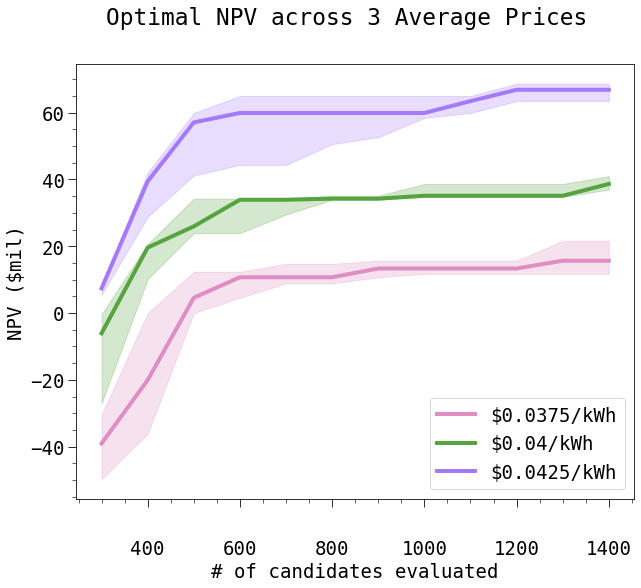

-6065352.302922368


In [129]:
ordering = ['EP3.75_GC_1_NPV', 'EP4_GC_1_NPV', 'EP4.25_GC_1_NPV']
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["$0.0375/kWh", "$0.04/kWh", "$0.0425/kWh"], loc='lower right')

plt.suptitle("Optimal NPV across 3 Average Prices")
plt.show()
print(baseline_value)

## Explore Results with only Solar & Battery Tax Incentives

{'energy_price_base': 3.75, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX'}


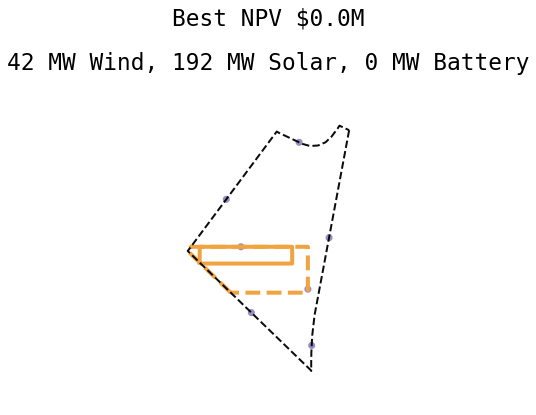

[13.442437254309148, 1.0, 1.7815201461041121, 2.4659729450958254, 0.5280016407689111, 0.5906494019207649, 0.3604529998936307, 0.47203467667476945, -1.7071199331389482, 0.9, 6.691525809267106, 3.1519852116340292, 0.6416508078943377, 0.0] 0.0 0.0 results


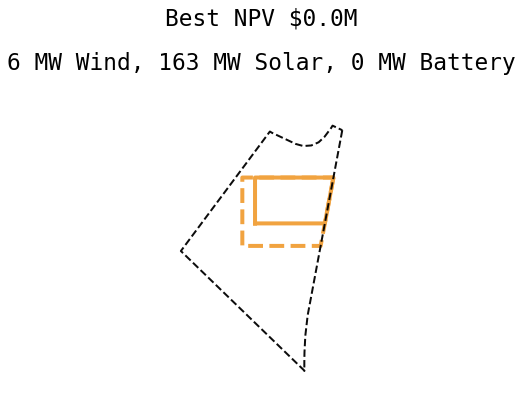

[8.269081830200706, 0.0, 1.7576779477160476, 2.296083879879545, 0.4488370426075911, 0.0, 1.0, 0.6949990701629806, -1.3361761251215176, 0.1, 4.9460419786108325, 2.357408051299235, 0.5435314886144933, 0.0] 0.0 0.0 results1


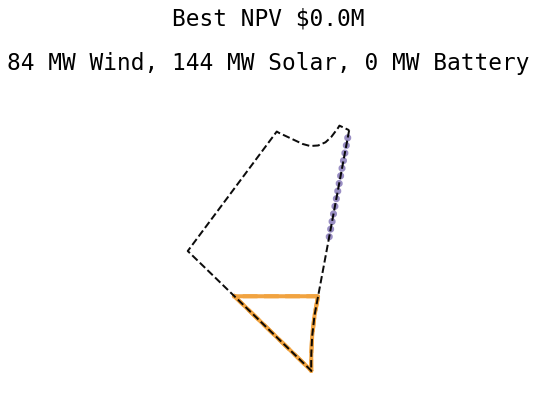

[0.022825317835730274, 1.0, 3.141592653589793, 2.645502702149426, 0.8398220115850453, 0.22727294737979936, 0.30469377255391994, 0.043781050453904624, -2.521830688583965, 0.1, 6.211907655466385, 5.618103387107796, 0.4809869166552619, 0.0] 0.0 0.0 results2
[0.022825317835730274, 1.0, 3.141592653589793, 2.645502702149426, 0.8398220115850453, 0.22727294737979936, 0.30469377255391994, 0.043781050453904624, -2.521830688583965, 0.1, 6.211907655466385, 5.618103387107796, 0.4809869166552619, 0.0] 0.0 0.0 -64379601.2260942


In [130]:
current_run = run_group = 'EP3.75_GC_0_NPV'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

{'energy_price_base': 4, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX'}


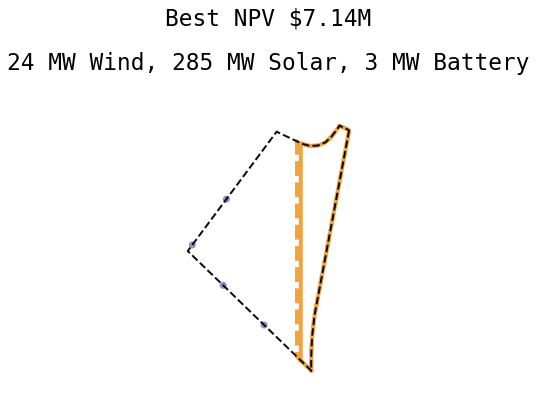

[6.526824363133516, 0.8045212465995535, 1.7416677820406306, 4.0, 0.7938849377381278, 0.06894104546681648, 0.9529395262176417, 0.9657167793503281, 2.3755700010620258, 0.1, 0.0, 0.0, 0.9507408866541239, 0.010125474970088054] 7138246.597248923 7138269.003685176 results


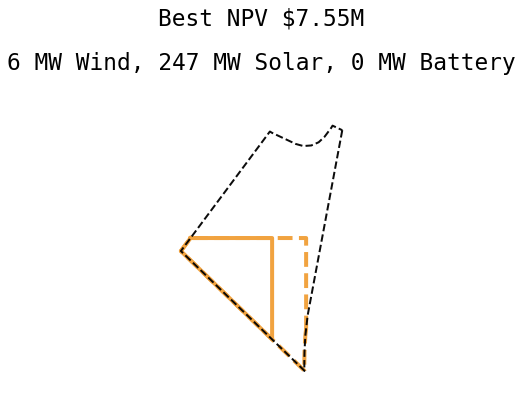

[6.983985397450944, 0.8055661167241684, 0.0, 1.7783091430411113, 0.7486059609214213, 0.0, 0.0, 0.1060988981504099, 0.15868374323303572, 0.1, 7.717893176214386, 7.991001004276951, 0.824970151551935, 0.00032697746704583256] 7554135.102193246 7554197.500238895 results1


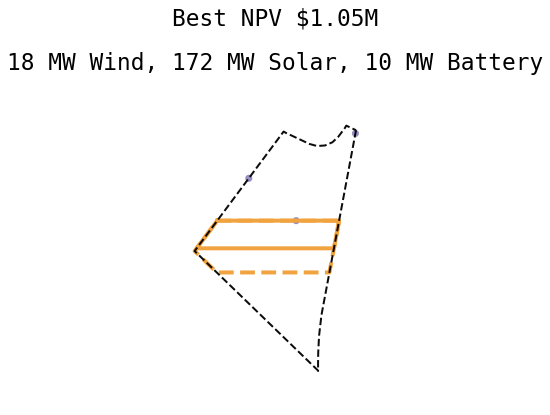

[16.4084191948276, 0.024382856399523867, 1.6372103217557918, 3.6863859338431957, 0.8805931543516522, 0.05384267978730062, 0.3676939194659762, 0.5563555784479581, -1.9712596640131093, 0.1, 5.376766589898428, 1.2016560178619038, 0.5735801396117124, 0.03289745528322969] 1048423.8683568423 1048425.4578586817 results2
[16.4084191948276, 0.024382856399523867, 1.6372103217557918, 3.6863859338431957, 0.8805931543516522, 0.05384267978730062, 0.3676939194659762, 0.5563555784479581, -1.9712596640131093, 0.1, 5.376766589898428, 1.2016560178619038, 0.5735801396117124, 0.03289745528322969] 1048425.4578586817 1048423.8683568423 -36350798.548924215


In [131]:
current_run = run_group = 'EP4_GC_0_NPV'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

{'energy_price_base': 4.25, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX'}


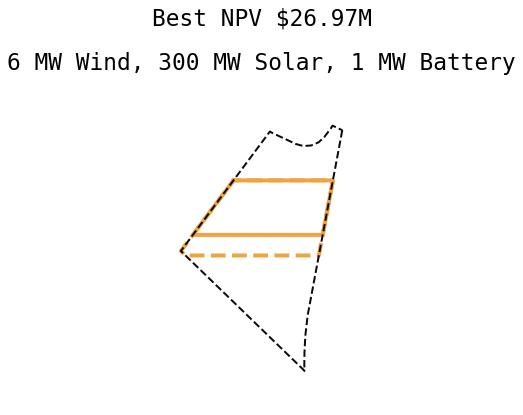

[9.439816104484358, 1.0, 0.8614830774847624, -0.060467357880696015, 0.8539377084179127, 0.015175834814650152, 0.34033088650974486, 0.6658096216090601, -4.0, 0.1, 4.438546254571851, 4.102668504144235, 1.0, 0.004592891706005013] 26966659.26263541 26966686.03299743 results


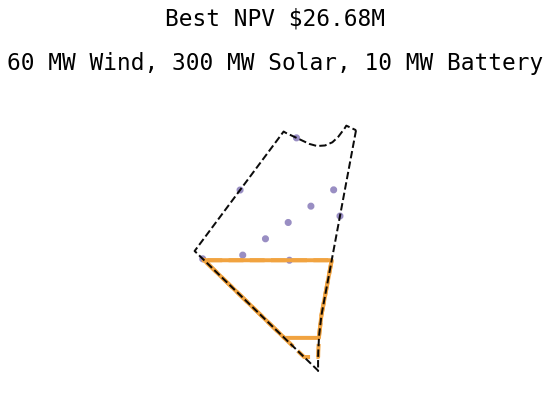

[10.534504933793002, 1.0, 3.141592653589793, -2.431568390943876, 0.12243595762601633, 0.17634436056605368, 0.0, 0.29320391458950196, -2.4829834115703293, 0.1, 4.060686902108825, 5.4404182179047496, 1.0, 0.03381007974478782] 26676608.09218317 26676642.846294105 results1


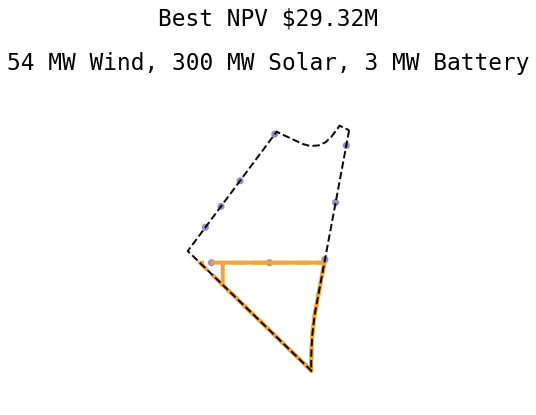

[6.668898285389989, 0.2667479500819712, 3.141592653589793, 1.2467727580680057, 0.38554307109486374, 0.1485446475981471, 0.5367749167505199, 0.13926477866524764, 0.3610686792864124, 0.1, 0.0, 7.327814085916537, 1.0, 0.010245800930107449] 29315707.661247123 29315768.70878321 results2
[6.668898285389989, 0.2667479500819712, 3.141592653589793, 1.2467727580680057, 0.38554307109486374, 0.1485446475981471, 0.5367749167505199, 0.13926477866524764, 0.3610686792864124, 0.1, 0.0, 7.327814085916537, 1.0, 0.010245800930107449] 29315768.70878321 29315707.661247123 -13844485.846713472


In [132]:
current_run = run_group = 'EP4.25_GC_0_NPV'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)
print(best_solution, evaluation, score, baseline_value)

-13844485.846713472
EP3.75_GC_0_NPV mean 0.0 stdev 0.0 median 0.0

EP4_GC_0_NPV mean 5.588008314251959 stdev 3.9966966192807587 median 7.138269003685176

EP4.25_GC_0_NPV mean 27.653032529358246 stdev 1.4472560120154239 median 26.96668603299743



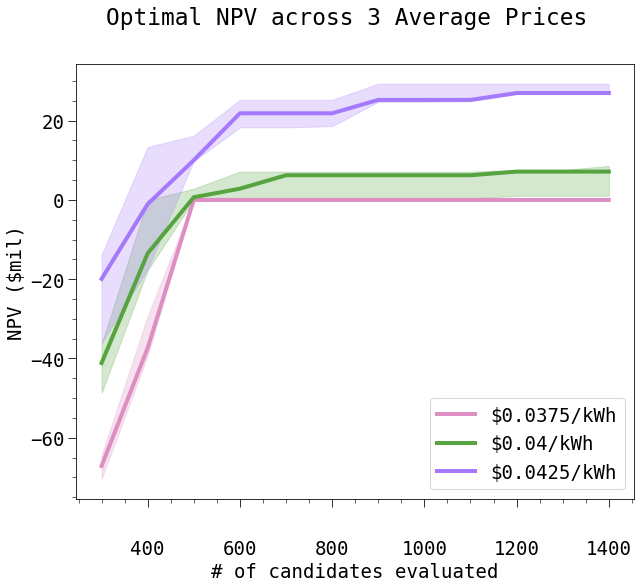

-13844485.846713472


In [133]:
ordering = ['EP3.75_GC_0_NPV', 'EP4_GC_0_NPV', 'EP4.25_GC_0_NPV']
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["$0.0375/kWh", "$0.04/kWh", "$0.0425/kWh"], loc='lower right')

plt.suptitle("Optimal NPV across 3 Average Prices")
plt.show()
print(baseline_value)

## Explore Results with only Solar & Battery Tax Incentives, Higher Capacity Payment

Could not fit 5976.057 kw into existing PV layout parameters of PVGridParameters(x_position=0.12305688561378192, y_position=0.06809056235416566, aspect_power=-4.0, gcr=0.8999545095468162, s_buffer=9.0, x_buffer=9.0)


{'energy_price_base': 3.75, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX', 'cp_capacity_payment_amount': 65000}


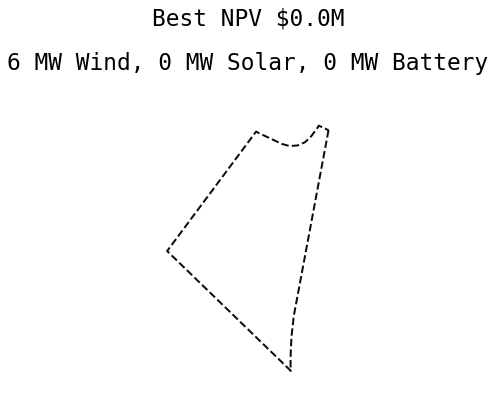

[9.927717103096938, 0.0, 3.141592653589793, -2.7047099149086784, 0.09828649175716003, 0.0, 0.12305688561378192, 0.06809056235416566, -4.0, 0.8999545095468162, 9.0, 9.0, 0.019920583146698423, 0.0] 0.0 0.0 results


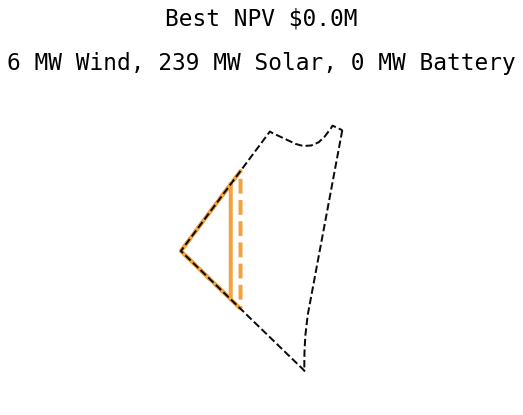

[6.628896644398563, 1.0, 0.0, -0.05471515449779485, 0.16343674621169635, 0.0, 0.0, 0.7790187440066318, 2.4031084755919307, 0.2995982646652823, 2.202500012555661, 1.579041126668135, 0.7978883579343372, 0.0] 0.0 0.0 results1


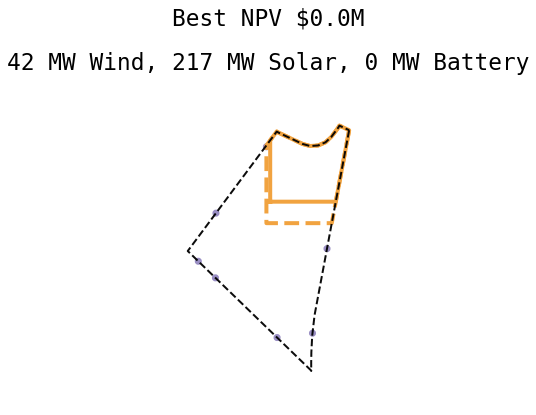

[10.336562825325515, 0.3023261583212016, 3.141592653589793, 1.2689384248560516, 0.9115494307965979, 0.12785443968443932, 0.8277610312217966, 1.0, 0.39632993118675625, 0.1, 4.675485904125248, 0.0, 0.7236168871625964, 0.0] 0.0 0.0 results2


In [135]:
current_run = run_group = 'EP3.75_GC_0_CAP'
runs = data_sets[run_group]
site_fig_size = (5,7)
print(runs['README'])
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)


{'energy_price_base': 4, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX', 'cp_capacity_payment_amount': 65000}


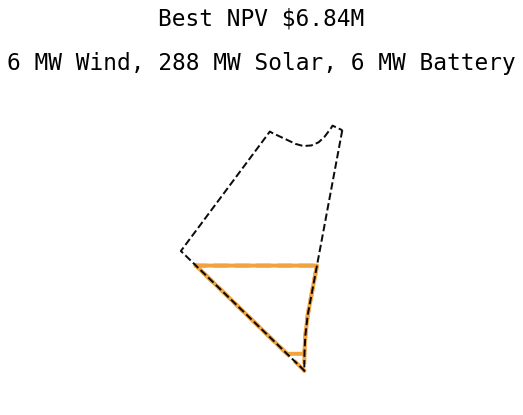

[6.985433059085157, 1.0, 0.36653996510078246, 4.0, 1.0, 0.0, 0.2694740093287909, 0.24984381898631322, -0.7664609001506671, 0.1, 4.72536985924333, 4.871403427767792, 0.9597445541507797, 0.019256075301153596] 6844230.452411537 6844257.255427122 results


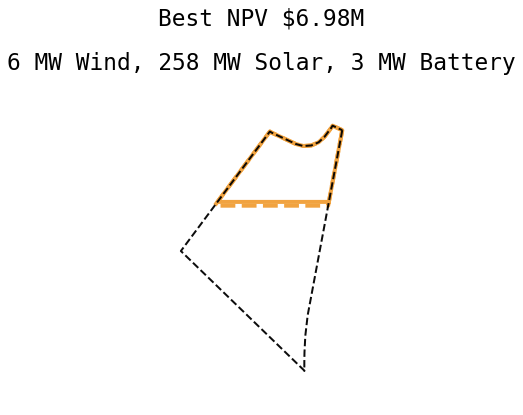

[12.027245481317511, 1.0, 3.141592653589793, 1.627727797922966, 0.35222584831758824, 0.0, 0.0, 1.0, -2.4952281825128138, 0.1, 0.0, 3.2291347296029516, 0.8597525859187687, 0.008752174884397234] 6978701.70568622 6978790.714682281 results1


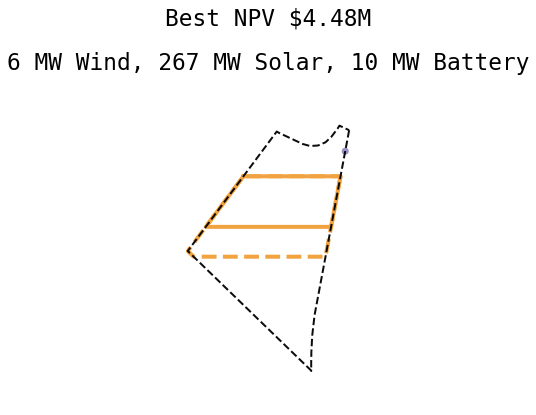

[1.8202504309547747, 1.0, 1.9907846292912874, 2.898330614316197, 0.8785175313075613, 0.01798549751247458, 0.6866412244730722, 0.6905560098487636, -3.7788313408379794, 0.1, 6.884483862340386, 7.2045952491697545, 0.8902798659824178, 0.03351519006021254] 4481582.711756227 4481642.685871184 results2


In [136]:
current_run = run_group = 'EP4_GC_0_CAP'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)

{'energy_price_base': 4.25, 'grid_charging': 0, 'pv_charging_only': 1, 'objective': 'NPV', 'pv_itc_fed_percent': 22, 'wind_ptc_fed_amount': [0.0], 'location': 'TX', 'cp_capacity_payment_amount': 65000}


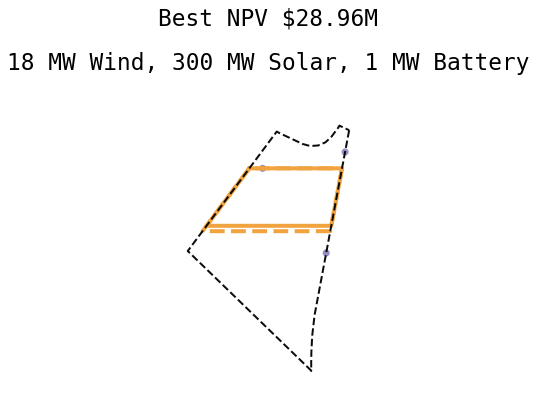

[11.689556402742486, 0.2303063650678705, 0.0, 1.818330797266029, 0.808763526754027, 0.04960023789497944, 0.5194286436583293, 0.708893965971118, -4.0, 0.1, 0.4236591371923919, 1.9720070443750148, 1.0, 0.002084108795142911] 28963224.586095367 28963247.142523408 results


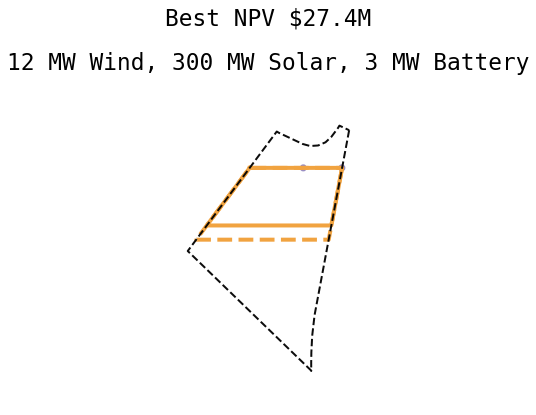

[4.097487252901563, 1.0, 1.3658947398720405, 3.3328797190879955, 0.5150560548163171, 0.04380345248996071, 0.875376758067915, 0.7105187529606302, -1.634243155768111, 0.1, 2.7542688760211624, 2.1492626287393843, 1.0, 0.011480582927245686] 27395634.652001347 27395640.590418696 results1


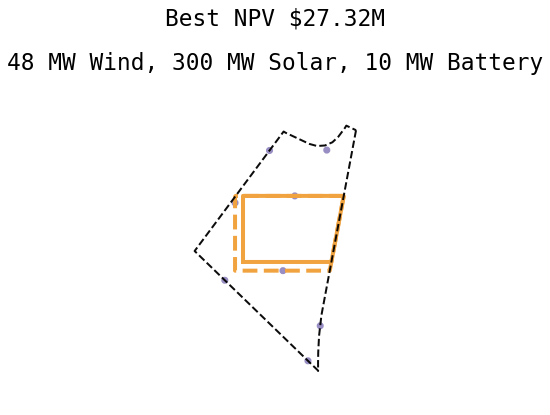

[14.29605738235482, 1.0, 0.0, -0.587588359488082, 0.5207665285719747, 0.13121059992417597, 0.8141556510936058, 0.579022604394933, -0.921600442906236, 0.1, 1.2995202634607086, 1.1047292587980704, 1.0, 0.03413791252696219] 27321720.1831431 27321723.379514158 results2


In [137]:
current_run = run_group = 'EP4.25_GC_0_CAP'
runs = data_sets[run_group]
print(runs['README'])
site_fig_size = (5,7)
best_solution, evaluation, score, baseline_value = plot_sites(runs, run_group, site_fig_size)

-19904881.8945475
EP3.75_GC_0_CAP mean 0.0 stdev 0.0 median 0.0

EP4_GC_0_CAP mean 6.101563551993529 stdev 1.4045043689105123 median 6.844257255427122

EP4.25_GC_0_CAP mean 28.406418350958646 stdev 0.9685187992113355 median 28.712956000969886



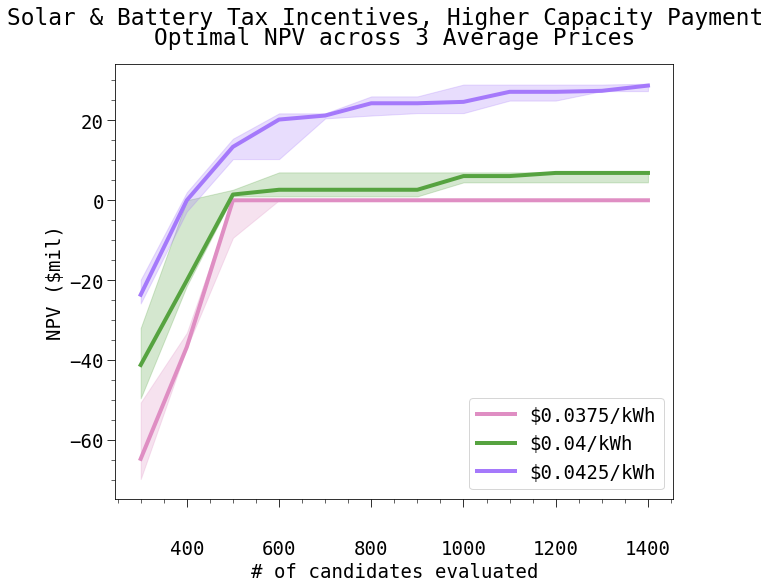

In [139]:
ordering = ['EP3.75_GC_0_CAP', 'EP4_GC_0_CAP', 'EP4.25_GC_0_CAP']
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering)
plt.legend(["$0.0375/kWh", "$0.04/kWh", "$0.0425/kWh"], loc='lower right')

plt.title("Optimal NPV across 3 Average Prices")
plt.suptitle("Solar & Battery Tax Incentives, Higher Capacity Payment")
plt.show()


# Across all 3 Run configurations

-19904881.8945475
EP3.75_GC_0_NPV mean 0.0 stdev 0.0 median 0.0

EP4_GC_0_NPV mean 5.588008314251959 stdev 3.9966966192807587 median 7.138269003685176

EP4.25_GC_0_NPV mean 27.653032529358246 stdev 1.4472560120154239 median 26.96668603299743

EP3.75_GC_1_NPV mean 16.34394824186923 stdev 4.984082684267058 median 15.658308896510123

EP4_GC_1_NPV mean 38.85806351287315 stdev 2.0193309440352585 median 38.63678339683705

EP4.25_GC_1_NPV mean 66.29981093901318 stdev 2.646997893759849 median 66.82785268381274

EP3.75_GC_0_CAP mean 0.0 stdev 0.0 median 0.0

EP4_GC_0_CAP mean 6.101563551993529 stdev 1.4045043689105123 median 6.844257255427122

EP4.25_GC_0_CAP mean 28.406418350958646 stdev 0.9685187992113355 median 28.712956000969886



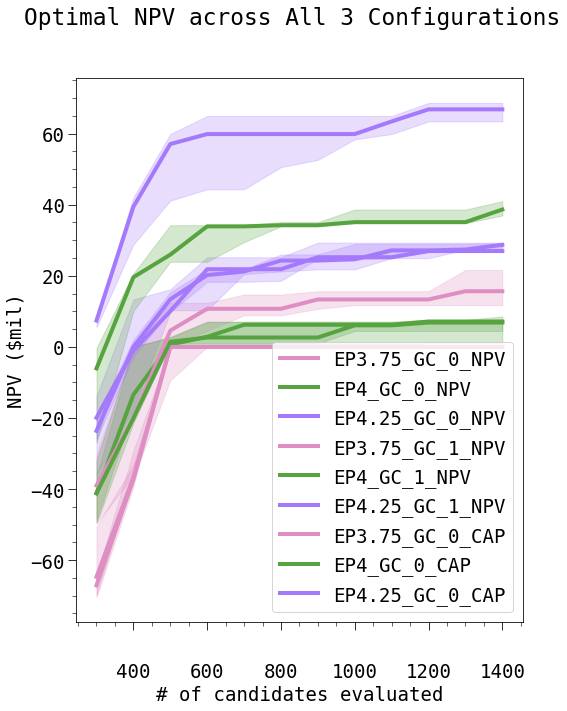

-19904881.8945475


In [147]:
ordering = ('EP3.75_GC_0_NPV', 'EP4_GC_0_NPV', 'EP4.25_GC_0_NPV', 'EP3.75_GC_1_NPV', 'EP4_GC_1_NPV', 'EP4.25_GC_1_NPV', 'EP3.75_GC_0_CAP', 'EP4_GC_0_CAP', 'EP4.25_GC_0_CAP')
print(baseline_value)
fig, ax, ax2 = plot_perf(aggregated_data_sets, 0.1, ordering, (8, 10))
plt.legend(['EP3.75_GC_0_NPV', 'EP4_GC_0_NPV', 'EP4.25_GC_0_NPV', 'EP3.75_GC_1_NPV', 'EP4_GC_1_NPV', 'EP4.25_GC_1_NPV', 'EP3.75_GC_0_CAP', 'EP4_GC_0_CAP', 'EP4.25_GC_0_CAP'], loc='lower right')

# ax.set_ylim(3.1, 4.5)
# ax.set_yticks([3.5, 4.0, 4.5])
# ax.set_xlim(0, 25000)
# ax.set_xticks([0,10000,20000,30000,40000,50000])
# ax2.set_yticks([219, 220, 221])
plt.suptitle("Optimal NPV across All 3 Configurations")
plt.show()
# plt.savefig(name + 'progress.svg')
print(baseline_value)